In [2]:
import os
import scipy
import logging
import tempfile
import numpy as np
import nibabel as nib
import multiprocessing
from dipy.data import get_sphere
from dipy.io import read_bvals_bvecs
from joblib import Parallel, delayed
from dipy.core.sphere import Sphere
from dipy.reconst.shm import sf_to_sh
from dipy.core.gradients import gradient_table_from_bvals_bvecs
from scilpy.reconst.multi_processes import fit_from_model, convert_sh_basis
from scilpy.reconst.raw_signal import compute_sh_coefficients
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.shm import real_sh_descoteaux_from_index, sh_to_sf
from scilpy.utils.bvec_bval_tools import (DEFAULT_B0_THRESHOLD,
                                          check_b0_threshold, identify_shells,
                                          is_normalized_bvecs, normalize_bvecs)

/home/local/VANDERBILT/kanakap/py38-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz').get_fdata()
vol = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.nii.gz')
og_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bvec'
ob_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/prequal_dwi_cat/sub-cIVs002_ses-s1Bx2_acq-b1000b2000n96r21x21x22peAPP_run-1_dwi.bval'
vec_folder = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/tracto_ip_lr_corr_1/Lemp/emp_Lcorrected_bvec'
val_folder = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/tracto_ip_lr_corr_1/Lemp/emp_Lcorrected_bval'
pk_corr_dwi1 = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs002/ses-s1Bx2/tracto_ip_lr_corr_1/emp_Lcorrected_sig.nii.gz').get_fdata()

In [4]:
def compute_dwi_attenuation(dwi_weights: np.ndarray, b0: np.ndarray):
    """ Compute signal attenuation by dividing the dwi signal with the b0.
    Parameters:
    -----------
    dwi_weights : np.ndarray of shape (X, Y, Z, #gradients)
        Diffusion weighted images.
    b0 : np.ndarray of shape (X, Y, Z)
        B0 image.
    Returns
    -------
    dwi_attenuation : np.ndarray
        Signal attenuation (Diffusion weights normalized by the B0).
    """
    b0 = b0[..., None]  # Easier to work if it is a 4D array.

    # Make sure that, in every voxels, weights are lower in the b0. Should
    # always be the case, but with the noise we never know!
    erroneous_voxels = np.any(dwi_weights > b0, axis=3)
    nb_erroneous_voxels = np.sum(erroneous_voxels)
    if nb_erroneous_voxels != 0:
        logging.info("# of voxels where `dwi_signal > b0` in any direction: "
                     "{}".format(nb_erroneous_voxels))
        dwi_weights = np.minimum(dwi_weights, b0)

    # Compute attenuation
    dwi_attenuation = dwi_weights / b0

    # Make sure we didn't divide by 0.
    dwi_attenuation[np.logical_not(np.isfinite(dwi_attenuation))] = 0.

    return dwi_attenuation

In [5]:
def val_emp(i,j,k,n,og_bval,bvec_stack,bval_stack,emp_sh,sh_order):
        dwi = n[i][j][k]
        vec = bvec_stack[i,j,k,:,:]
        val = bval_stack[i,j,k,:]
        gradient_table = gradient_table_from_bvals_bvecs(val, vec)
        sh_order=sh_order
        basis_type='tournier07'
        smooth=0.00
        use_attenuation=True
        force_b0_threshold=False
        mask=None
        sphere=None

        # Extracting infos
        b0_mask = gradient_table.b0s_mask
        bvecs = gradient_table.bvecs
        bvals = gradient_table.bvals
        
        dwi = np.reshape(dwi,[1,1,1,bvals.shape[0]])

        if not is_normalized_bvecs(bvecs):
                logging.warning("Your b-vectors do not seem normalized...")
                bvecs = normalize_bvecs(bvecs)

        b0_threshold = check_b0_threshold(force_b0_threshold, bvals.min())

        # Ensure that this is on a single shell.
        shell_values, _ = identify_shells(bvals)
        shell_values.sort()
        # if shell_values.shape[0] != 2 or shell_values[0] > b0_threshold:
        #     raise ValueError("Can only work on single shell signals.")

        # Keeping b0-based infos
        bvecs = bvecs[np.logical_not(b0_mask)]
        weights = dwi[..., np.logical_not(b0_mask)]

        b0 = dwi[..., b0_mask].mean(axis=3)
        norm_gg = np.divide(bvals[np.logical_not(b0_mask)] , og_bval[np.logical_not(b0_mask)])
        weights_scaled = b0 * np.exp (np.divide( (np.log (np.divide(weights,b0)) ) , norm_gg))

        # Compute attenuation using the b0.
        if use_attenuation:
                weights_scaled = compute_dwi_attenuation(weights_scaled, b0)

        # # Get cartesian coords from bvecs # from here cut debugging
        sphere = Sphere(xyz=bvecs)

        # SF TO SH
        # Fit SH
        sh = sf_to_sh(weights_scaled, sphere, sh_order, basis_type, smooth=smooth)
        emp_sh[i,j,k,:] = sh


In [6]:
def val_pk(dwi1,og_bval,og_bvec,sh_order):
    og_gradient_table = gradient_table_from_bvals_bvecs(og_bval, og_bvec)
    pk_sh = compute_sh_coefficients(dwi1,og_gradient_table,sh_order=sh_order,basis_type='tournier07',use_attenuation=True,smooth=0.00)
    return pk_sh

In [7]:
og_bval, og_bvec = read_bvals_bvecs(ob_file,og_file)
ind_1000 = np.where(og_bval == 1000)
ind_2000 = np.where(og_bval == 2000)
ind_b0 = np.nonzero(og_bval==0)
ind_b0 = np.squeeze(ind_b0)
ind_0_1000 = np.where((og_bval == 0) | (og_bval == 1000))
ind_0_2000 = np.where((og_bval == 0) | (og_bval == 2000))

# for 1000
len1 = ind_0_1000[0]
sh_order = 6
pk_sh1000 = val_pk(pk_corr_dwi1[:,:,:,len1],og_bval[len1],og_bvec[len1],sh_order)
# for 2000
len2 = ind_0_2000[0]
sh_order = 8
pk_sh2000 = val_pk(pk_corr_dwi1[:,:,:,len2],og_bval[len2],og_bvec[len2,:],sh_order)

/home-nfs2/local/VANDERBILT/kanakap/scilpy_py37-venv/scilpy/scilpy/reconst/raw_signal.py:117: RuntimeWarning: invalid value encountered in true_divide
  dwi_attenuation = dwi_weights / b0


In [18]:
bvec_vols = []
for i in sorted(os.listdir(vec_folder)):
    if i.endswith('.nii.gz'):
        bvec_vol = nib.load(vec_folder + '/' + i).get_fdata()
        bvec_vol = np.expand_dims(bvec_vol,4)
        bvec_vol = np.transpose(bvec_vol,(0,1,2,4,3))
        bvec_vols.append(bvec_vol)
bvec_stack = np.stack(bvec_vols,3)
bvec_stack = bvec_stack.squeeze()

bval_vols = []
for i in sorted(os.listdir(val_folder)):
    if i.endswith('.nii.gz'):
        bval_vol = nib.load(val_folder + '/' + i).get_fdata()
        bval_vols.append(bval_vol)
bval_stack = np.stack(bval_vols,3)

In [19]:
num_cores = 10
path = tempfile.mkdtemp()
xaxis = range(n.shape[0])
yaxis = range(n.shape[1])
zaxis = range(n.shape[2]) 

# for dwi with 0 1000
len1 = ind_0_1000[0]
dwi_hat_path1 = os.path.join(path,'emp_sh1000.mmap')
emp_sh1000 = np.memmap(dwi_hat_path1, dtype=float, shape=(n.shape[0],n.shape[1],n.shape[2],28), mode='w+')
data = n[:,:,:,len1]
org_bval = og_bval[len1]
corr_bvec = bvec_stack[:,:,:,len1,:]
corr_bval = bval_stack[:,:,:,len1]
sh_order=6
results = Parallel(n_jobs=num_cores)(delayed(val_emp)(i,j,k,data,org_bval,corr_bvec,corr_bval,emp_sh1000,sh_order) for k in zaxis for j in yaxis for i in xaxis)

/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered

In [20]:

num_cores = 10
path = tempfile.mkdtemp()
xaxis = range(n.shape[0])
yaxis = range(n.shape[1])
zaxis = range(n.shape[2]) 

len2 = ind_0_2000[0]
dwi_hat_path2 = os.path.join(path,'emp_sh2000.mmap')
emp_sh2000 = np.memmap(dwi_hat_path2, dtype=float, shape=(n.shape[0],n.shape[1],n.shape[2],45), mode='w+')
data = n[:,:,:,len2]
org_bval = og_bval[len2]
corr_bvec = bvec_stack[:,:,:,len2,:]
corr_bval = bval_stack[:,:,:,len2]
sh_order=8

results = Parallel(n_jobs=num_cores)(delayed(val_emp)(i,j,k,data,org_bval,corr_bvec,corr_bval,emp_sh2000,sh_order) for k in zaxis for j in yaxis for i in xaxis)

/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered in log
/tmp/ipykernel_386262/762356144.py:39: RuntimeWarning: invalid value encountered

In [29]:
emp = np.stack((emp_sh1000,emp_sh2000))
pk = np.stack((pk_sh1000,pk_sh2000))

ValueError: all input arrays must have the same shape

In [34]:
emp.shape

(2, 112, 112, 54, 66)

In [32]:
pk_sh1000.shape 

(112, 112, 54, 66)

In [31]:
pk_sh2000.shape

(112, 112, 54, 66)

In [12]:
emp_sh2000[45][45][30][45]

-0.009226272515282363

In [13]:
pk_sh2000[45][45][30][45]

-0.008742835394595416

In [30]:
import numpy as np
import torch

def angularCorrCoeff(p_v, q_v):

    p = p_v.shape[-1]
    q = q_v.shape[-1]
    nCoeffs = min([p, q])

    p_v = p_v[..., 0:nCoeffs]
    q_v = q_v[..., 0:nCoeffs]

    zmp_v = p_v[..., 1:nCoeffs]
    zmq_v = q_v[..., 1:nCoeffs]

    np_v = np.rollaxis(zmp_v, -1)/ (np.sqrt(np.sum(zmp_v * np.conj(zmp_v), axis=-1)))
    nq_v = np.rollaxis(zmq_v, -1)/ (np.sqrt(np.sum(zmq_v * np.conj(zmq_v), axis=-1)))
    
    np_v = np.rollaxis(np_v,0,len(np_v.shape))
    nq_v = np.rollaxis(nq_v,0,len(nq_v.shape))

    acc = np.sum(np_v * np.conj(nq_v), axis=-1)

    return acc

In [36]:
acc1 = angularCorrCoeff(emp_sh2000,pk_sh2000)

/tmp/ipykernel_98703/387905043.py:16: RuntimeWarning: invalid value encountered in true_divide
  np_v = np.rollaxis(zmp_v, -1)/ (np.sqrt(np.sum(zmp_v * np.conj(zmp_v), axis=-1)))
/tmp/ipykernel_98703/387905043.py:17: RuntimeWarning: invalid value encountered in true_divide
  nq_v = np.rollaxis(zmq_v, -1)/ (np.sqrt(np.sum(zmq_v * np.conj(zmq_v), axis=-1)))


In [17]:
acc1.shape

(112, 112, 54)

In [35]:
acc1 = angularCorrCoeff(emp,pk)

/tmp/ipykernel_10004/387905043.py:16: RuntimeWarning: invalid value encountered in true_divide
  np_v = np.rollaxis(zmp_v, -1)/ (np.sqrt(np.sum(zmp_v * np.conj(zmp_v), axis=-1)))
/tmp/ipykernel_10004/387905043.py:17: RuntimeWarning: invalid value encountered in true_divide
  nq_v = np.rollaxis(zmq_v, -1)/ (np.sqrt(np.sum(zmq_v * np.conj(zmq_v), axis=-1)))


In [37]:
np.nanmean(np.nanmean(acc1))

0.9740121532855619

In [50]:
from scilpy.reconst.sh import compute_rish

In [166]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)
from scipy import ndimage
mask = ndimage.binary_dilation(mask, iterations=1).astype(mask.dtype)

In [167]:
pk_rish1000, final_orders = compute_rish(pk_sh1000,mask=mask)
emp_rish1000, final_orders = compute_rish(emp_sh1000,mask=mask)

In [168]:
emp_rish2000, final_orders = compute_rish(emp_sh2000,mask=mask)
pk_rish2000, final_orders = compute_rish(pk_sh2000,mask=mask)

In [58]:
emp_rish2000.shape

(112, 112, 54, 5)

In [60]:
acc2 = angularCorrCoeff(emp_rish1000[:,:,:,3],pk_rish1000[:,:,:,3])

/tmp/ipykernel_98703/387905043.py:16: RuntimeWarning: invalid value encountered in true_divide
  np_v = np.rollaxis(zmp_v, -1)/ (np.sqrt(np.sum(zmp_v * np.conj(zmp_v), axis=-1)))
/tmp/ipykernel_98703/387905043.py:17: RuntimeWarning: invalid value encountered in true_divide
  nq_v = np.rollaxis(zmq_v, -1)/ (np.sqrt(np.sum(zmq_v * np.conj(zmq_v), axis=-1)))


In [61]:
np.nanmean(np.nanmean(acc2))

0.9920426856686418

In [72]:
ind_0_1000 = np.where((og_bval == 0) | (og_bval == 1000))

In [75]:
ind_0_1000

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  55,  64,  73,  82,
         91, 100, 109, 111]),)

In [78]:
pk_sh1000 = val_pk(pk_corr_dwi1[:,:,:,len1],og_bval[len1],og_bvec[len1,:])

/home-nfs2/local/VANDERBILT/kanakap/scilpy_py37-venv/scilpy/scilpy/reconst/raw_signal.py:117: RuntimeWarning: invalid value encountered in true_divide
  dwi_attenuation = dwi_weights / b0


In [79]:
len1

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  55,  64,  73,  82,
        91, 100, 109, 111])

In [2]:
acc1000 = [0.8282973981832714, 0.8228604762732795,0.7930699216711522, 0.7983260829709444,0.804515810053933]

In [3]:
acc2000 = [0.8326090974203082,0.8164530412158586,0.7901226112354409,0.8070315817082493,0.8000860330690326]

In [49]:
acc1000 = [0.9770712734354825,0.9795263449200603,0.9757020790440663,0.9828990069525622,0.9643193990910122]
acc2000 = [0.972894914151945,0.9737851234494219,0.9740020420001775,0.9789930151456134,0.9615602517669753]

In [141]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0, 0.5, 'Mean ACC')

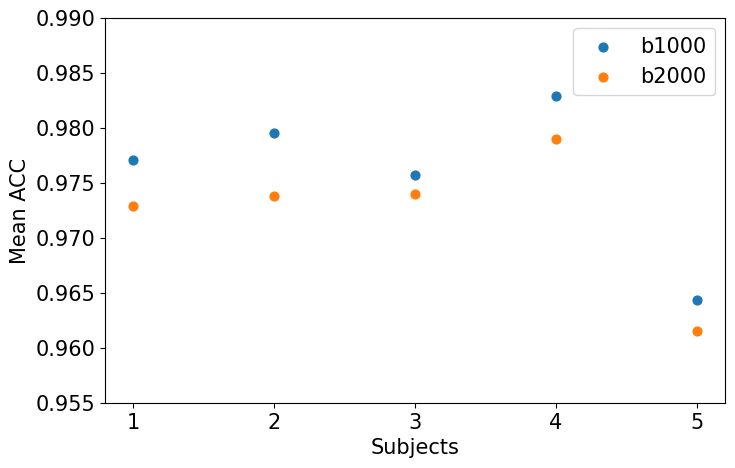

In [67]:
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize=(8,5)) 
plt.scatter(range(5),acc1000,40,label='b1000')
plt.scatter(range(5),acc2000,40,label='b2000')
plt.legend()
plt.ylim((0.955,0.99))
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel('Subjects')
plt.ylabel('Mean ACC')
# plt.ylabel('ACC between SH of signal reconst. \n and SH of emp. voxelwise')

In [1]:
acc1000 = [0.9904828919394973,0.987087871556337,0.9908236392712096,0.9875183958383225,0.9891097518815941]
acc2000 = [0.9792517992862245,0.9658582417455683,0.9883785019510217,0.9826812535794488,0.9804747002887525]

Text(0, 0.5, 'Mean ACC')

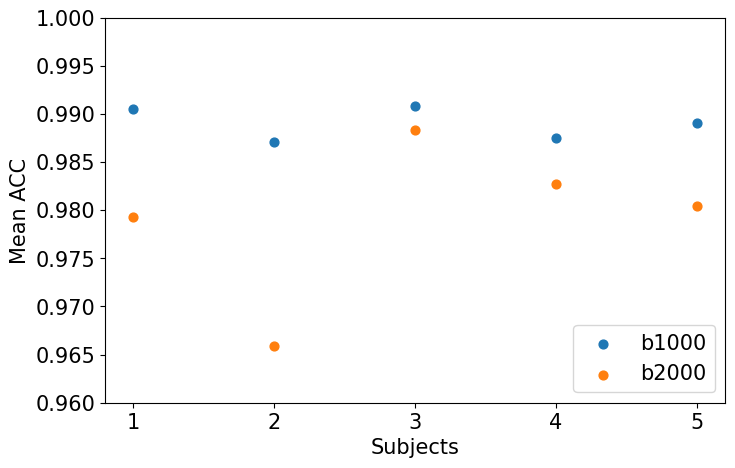

In [71]:
plt.rcParams.update({'font.size':15})
fig, ax = plt.subplots(figsize=(8,5)) 
plt.scatter(range(5),acc1000,40,label='b1000')
plt.scatter(range(5),acc2000,40,label='b2000')
plt.legend(loc='lower right')
plt.ylim((0.96,1))
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel('Subjects')
plt.ylabel('Mean ACC')

In [170]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)
from scipy import ndimage
mask = ndimage.binary_dilation(mask, iterations=1).astype(mask.dtype)

In [171]:
pk_rish1000, final_orders = compute_rish(pk_sh1000,mask=mask)
emp_rish1000, final_orders = compute_rish(emp_sh1000,mask=mask)

In [172]:
emp_rish2000, final_orders = compute_rish(emp_sh2000,mask=mask)
pk_rish2000, final_orders = compute_rish(pk_sh2000,mask=mask)

In [99]:

import math
MSE = np.square(pk_rish2000[:,:,:,0] / pk_rish2000[:,:,:,0].max() ,emp_rish2000[:,:,:,0] / emp_rish2000[:,:,:,0].max()).mean() 
RMSE = math.sqrt(MSE)

In [109]:
MSE = np.square(np.std(pk_rish1000[:,:,:,0]) ,emp_rish1000[:,:,:,0]).mean()
RMSE = math.sqrt(MSE) / np.mean(emp_rish1000[:,:,:,0]) 

In [133]:
MSE = np.square(np.std(pk_rish1000[:,:,:,0]) ,emp_rish1000[:,:,:,0]).mean()
RMSE = math.sqrt(MSE) / (np.mean(emp_rish1000[:,:,:,0]) )

In [134]:
RMSE

2.1417635789677185e-51

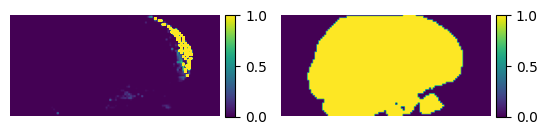

In [173]:

slice_idx = 60
slice = pk_rish1000[:,:,:,0] - emp_rish1000[:,:,:,0]
slice = slice[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
m = 0
M = 1
plt.subplot(1,2,1)
plt.axis('off')
cmap = plt.get_cmap('viridis')
im = plt.imshow(np.abs(slice),vmin=m, vmax=M, cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)


slice = mask[slice_idx, :,:]
slice = np.flip(np.rot90(slice,3))
slice = np.nan_to_num(slice)
plt.subplot(1,2,2)
plt.axis('off')
cmap = plt.get_cmap('viridis')
m = 0
M = 1
im = plt.imshow(np.abs(slice), vmin=m, vmax=M, cmap=cmap)
#im = plt.imshow(np.abs(slice),cmap=cmap)
divider = make_axes_locatable(plt.gca())
ax = divider.append_axes("right", size="5%", pad=0.05)
a = plt.colorbar(im, cax=ax)

In [135]:
def ape(predict,true):
    err_fa = predict - true
    pe_fa = (err_fa / true) * 100
    ape_fa = np.abs(pe_fa)
    return np.mean(ape_fa)

In [137]:
ape(emp_rish1000[:,:,:,0],emp_rish1000[:,:,:,0])

0.0

In [115]:
np.max(emp_rish1000[:,:,:,0]) - np.min(emp_rish1000[:,:,:,0]) 

0.0

In [132]:
np.min(emp_rish1000[:,:,:,3])

0.0

In [114]:
RMSE

inf

In [101]:
dist = np.abs(np.subtract(pk_rish2000[:,:,:,0] / pk_rish2000[:,:,:,0].max() ,emp_rish2000[:,:,:,0] / emp_rish2000[:,:,:,0].max()))

In [102]:
np.mean(dist)

1.2096259637751333e-07

In [72]:
MSE = np.square(np.subtract(pk_rish2000[50][50][30] /pk_rish2000[50][50][30] ,emp_rish2000[50][50][30])).mean() 
RMSE = math.sqrt(MSE)

6.838279364637656e-10

In [59]:
emp_rish2000[50][50][30]

array([0.80511498, 0.06307816, 0.00540365, 0.00476417, 0.00924936])

In [73]:
print(RMSE)

1.040646494276788e-09


In [37]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [44]:
s = np.square(np.subtract(pk_rish1000[:,:,:,0],emp_rish1000[:,:,:,0]))

In [49]:
math.sqrt(np.nanmean(s))

3.6048769466975528e+50

In [69]:
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mrtrix_mask.nii').get_fdata()
mask = mask.astype(int)